<a href="https://colab.research.google.com/github/Ry02024/DXsales_streamlitML/blob/main/App_PBL01_%E6%BC%94%E7%BF%9204_Ry0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# システムの概要

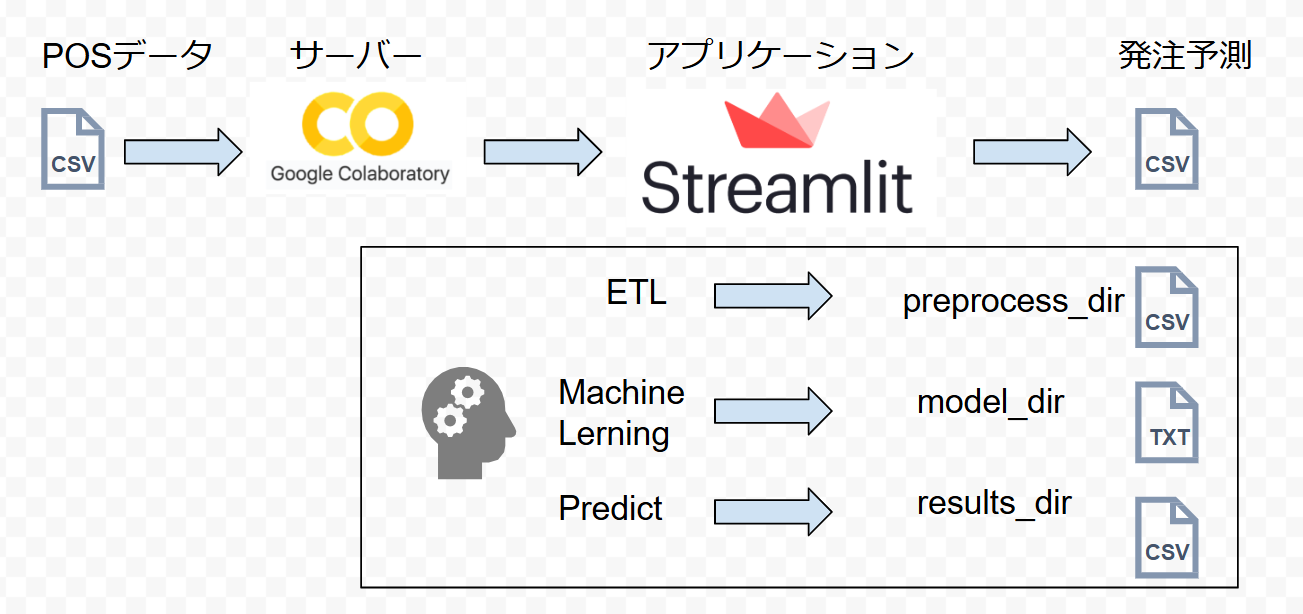

# 初期設定

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 環境構築

In [1]:
!pip install streamlit -q
!pip install pyngrok -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 699.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 2.6 MB/s eta 0:00:00


In [2]:
import streamlit as st
from pyngrok import ngrok

In [3]:
from google.colab import userdata
NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')

In [4]:
from pyngrok import ngrok
import os

# ngrokトークンを設定
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

In [5]:
import os

# Streamlit設定ファイルのディレクトリを作成
os.makedirs('/root/.streamlit', exist_ok=True)

# config.tomlファイルを作成して最大アップロードサイズを設定
with open('/root/.streamlit/config.toml', 'w') as f:
    f.write("""
[server]
maxUploadSize = 1024
""")

#アプリの起動

In [6]:
!pip install jpholiday -q
!git clone https://github.com/Ry02024/DXsales_streamlitML.git

Cloning into 'DXsales_streamlitML'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 104 (delta 39), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (104/104), 228.69 KiB | 1.23 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [19]:
%%writefile streamlit_app.py
import sys
import os
import streamlit as st
import pandas as pd
from DXsales_streamlitML.EBProM.execute import execute_preprocessing, execute_training, execute_prediction

# 各タスクの完了フラグを初期化
if "preprocessing_done" not in st.session_state:
    st.session_state["preprocessing_done"] = False
if "training_done" not in st.session_state:
    st.session_state["training_done"] = False
if "prediction_done" not in st.session_state:
    st.session_state["prediction_done"] = False

# データをロードするヘルパー関数
def load_data(uploaded_file, description):
    with st.spinner(f"{description}を読み込んでいます..."):
        return pd.read_csv(uploaded_file)

# Streamlitアプリケーション
def main():
    st.title('モデルのトレーニングと予測')

    # 各ディレクトリの指定
    save_dir = st.text_input("前処理データ保存ディレクトリ", value="Data/")
    model_save_dir = st.text_input("モデル保存ディレクトリ", value="Models/")
    prediction_save_dir = st.text_input("予測結果保存ディレクトリ", value="Predictions/")

    # タスク選択
    task_option = st.sidebar.radio("実行するタスクを選択してください", ("前処理", "機械学習", "予測"))

    if task_option == "前処理":
        sales_file = st.sidebar.file_uploader("売上データファイル (sales_history.csv)", type=["csv"], key="sales")
        item_file = st.sidebar.file_uploader("商品データファイル (item_categories.csv)", type=["csv"], key="item")
        category_file = st.sidebar.file_uploader("カテゴリデータファイル (category_names.csv)", type=["csv"], key="category")
        test_file = st.sidebar.file_uploader("テストデータファイル (test.csv)", type=["csv"], key="test")

        if sales_file and item_file and category_file and test_file:
            sales_df = load_data(sales_file, "売上データ")
            item_df = load_data(item_file, "商品データ")
            category_df = load_data(category_file, "カテゴリデータ")
            test_df = load_data(test_file, "テストデータ")

            if st.button("前処理と特徴量生成を実行"):
                with st.spinner("前処理と特徴量生成を実行しています..."):
                    execute_preprocessing(sales_df, item_df, category_df, test_df, save_dir)
                st.success("前処理と特徴量生成が完了しました。")

        # 前処理が完了した場合、ダウンロードボタンを表示
        if st.session_state["preprocessing_done"]:
            with open(st.session_state["train_path"], "rb") as file:
                st.download_button(label="Download train_df.csv", data=file, file_name="train_df.csv", mime="text/csv")
            with open(st.session_state["validation_path"], "rb") as file:
                st.download_button(label="Download validation_df.csv", data=file, file_name="validation_df.csv", mime="text/csv")
            with open(st.session_state["test_path"], "rb") as file:
                st.download_button(label="Download test_df.csv", data=file, file_name="test_df.csv", mime="text/csv")

    elif task_option == "機械学習":
        # トレーニングが完了している場合は、データの読み込みや訓練ボタンを表示せず、ダウンロードボタンのみ表示
        if st.session_state.get("training_done", False):
            with open(st.session_state["model_path"], "rb") as file:
                st.download_button(label="Download lgbm_model.txt", data=file, file_name="lgbm_model.txt", mime="text/plain")
        else:
            # データが未読み込みの場合のみ、データを読み込む
            train_file = st.sidebar.file_uploader("訓練データファイル (train_df.csv)", type=["csv"], key="train")
            valid_file = st.sidebar.file_uploader("検証データファイル (validation_df.csv)", type=["csv"], key="valid")

            # ファイルがアップロードされた場合にのみデータを読み込み、セッションステートに保存
            if train_file is not None and valid_file is not None:
                if "data_loaded" not in st.session_state:
                    st.session_state["train_df"] = load_data(train_file, "訓練データ")
                    st.session_state["valid_df"] = load_data(valid_file, "検証データ")
                    st.session_state["data_loaded"] = True  # データ読み込み済みフラグ

            # データが読み込まれている場合のみトレーニング開始ボタンを表示
            if st.session_state.get("data_loaded", False):
                num_iterations = st.number_input("学習回数を指定", min_value=1, value=1000)

                if st.button("モデルのトレーニングを開始"):
                    with st.spinner("モデルのトレーニングを実行しています..."):
                        execute_training(st.session_state["train_df"], st.session_state["valid_df"], model_save_dir, num_iterations)
                        st.success("モデルのトレーニングが完了しました。")
                        st.session_state["training_done"] = True  # トレーニング完了フラグを設定

                # トレーニングが完了した場合、ダウンロードボタンを表示
                if st.session_state.get("training_done", False):
                    with open(st.session_state["model_path"], "rb") as file:
                        st.download_button(label="Download lgbm_model.txt", data=file, file_name="lgbm_model.txt", mime="text/plain")

    elif task_option == "予測":
        model_file = st.sidebar.file_uploader("モデルファイル (lgbm_model.txt)", type=["txt"], key="model")
        test_file = st.sidebar.file_uploader("テストデータファイル (test_df.csv)", type=["csv"], key="test")

        if model_file and test_file:
            test_df = load_data(test_file, "テストデータ")

            if st.button("予測を実行"):
                with st.spinner("予測を実行しています..."):
                    execute_prediction(model_file, test_df, prediction_save_dir)
                st.success("予測が完了しました。")

        # 予測が完了した場合、ダウンロードボタンを表示
        if st.session_state["prediction_done"]:
            with open(st.session_state["prediction_path"], "rb") as file:
                st.download_button(label="Download predictions.csv", data=file, file_name="predictions.csv", mime="text/csv")

if __name__ == '__main__':
    main()


Overwriting streamlit_app.py


In [7]:
# ngrokを介してStreamlitを公開
public_url = ngrok.connect(addr='8501')
print('Public URL:', public_url)

Public URL: NgrokTunnel: "https://4fae-34-125-105-144.ngrok-free.app" -> "http://localhost:8501"


In [21]:
# Streamlitアプリケーションの起動
!streamlit run streamlit_app.py >/dev/null

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [8]:
# Streamlitアプリケーションの起動
!streamlit run DXsales_streamlitML/streamlit_app.py >/dev/null

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# 参考

1. KUBOKOさんのスクリプト（AI Quest 2020）, 経産省・SIGNATE